### Imports and Colormaps

In [25]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import tifffile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from align.alignment import BMAligner, MouseAtlas
from glob import glob
import json
from tqdm import tqdm
from skimage.transform import resize as skiresize
from phathom import io

# multiprocessing
from functools import partial
from itertools import repeat
from multiprocessing import Pool

ATLAS_PATH = "/media/share5/MYK/ATLAS/mouse"
# Region Labels
rl_file = os.path.join(ATLAS_PATH, 'AllBrainRegions_Dev.csv')
df = pd.read_csv(rl_file)


# Generate Colormaps
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# define top and bottom colormaps 

data = np.random.random([100, 100]) * 10

# create colormaps
N = 256
magenta = np.ones((N, 4))
magenta[:, 0] = np.linspace(255/N, 0, N) # R = 255
magenta[:, 1] = np.linspace(0, 0, N) # G = 0
magenta[:, 2] = np.linspace(255/N, 0, N)  # B = 255
magenta_cmp = ListedColormap(magenta)
magenta_r_cmp = magenta_cmp.reversed()

cyan = np.ones((N, 4))
cyan[:, 0] = np.linspace(0, 0, N) # R = 255
cyan[:, 1] = np.linspace(255/N, 0, N) # G = 0
cyan[:, 2] = np.linspace(255/N, 0, N)  # B = 255
cyan_cmp = ListedColormap(cyan)
cyan_r_cmp = cyan_cmp.reversed()

color = np.ones((N, 4))
color[:, 0] = np.linspace(0, 0, N) # R = 255
color[:, 1] = np.linspace(0, 255/256, N) # G = 232
color[:, 2] = np.linspace(0, 255/256, N)  # B = 11
cyan = ListedColormap(color)
cyan_r = cyan.reversed()

## Load params and creat MouseAtlas Objects

In [14]:
data1 = {
    'E15.5': ['/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230217_13_20_42_172_E15.5_aGFP_none_CD206',
              '/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206'],
}
rois = {
    "E15.5": [ 88, 130, 210],
}

In [59]:
age = 'E15.5'
wd = data1[age][1]
roi_z, roi_y, roi_x = rois[age]
# load params
params_f = os.path.join(wd, 'params.json')
with open(params_f) as fp:
    params = json.load(fp)

In [60]:
def get_af_tif(ann_tif):
    ann_tif_file = os.path.basename(ann_tif)
    af_tif = ann_tif_file.replace("annotation", "autofluorescence")
    return os.path.join(os.path.dirname(ann_tif), af_tif)

align_info = params['align_info']
raw_tiff_dir = os.path.join(wd, params[params['marker']]['tif_rel_path'])
alignment_json = os.path.join(wd, align_info['alignment_json'])
rescaled_alignment_json = os.path.join(wd, align_info['rescaled_alignment_json'])
ann_tif = os.path.join(ATLAS_PATH, align_info['ann_tif'])
af_tif = get_af_tif(ann_tif)
moving_tif = os.path.join(wd, align_info['downsampled_tif'])
print(raw_tiff_dir)
print(alignment_json)
print(rescaled_alignment_json)
print(ann_tif)
print(af_tif)
print(moving_tif)

# Create mouse atlas
ma = MouseAtlas(alignment_json, rl_file, ann_tif)
ma_s = MouseAtlas(rescaled_alignment_json, rl_file, ann_tif)

# get Raw Zarr stack
moving_zarr = io.zarr.open(os.path.join(wd, params[params['marker']]['zarr_rel_path']))
print(moving_zarr.shape, moving_zarr.chunks)

/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/Ex_488_Em_0_destriped_stitched_downsampled2x
/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/AntiGFP_alignment.json
/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/rescaled_AntiGFP_alignment.json
/media/share5/MYK/ATLAS/mouse/annotation_E15pt5_sagittal_brain.tif
/media/share5/MYK/ATLAS/mouse/autofluorescence_E15pt5_sagittal_brain.tif
/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/AntiGFP_downsampled_flipX_flipY.tif
MouseAtlas(): ajson:  /media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/AntiGFP_alignment.json
MouseAtlas(): ajson:  /media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/rescaled_AntiGFP_alignment.json
(2400, 5325, 2750) (100, 128, 128)


## Alignment Results

### Functions

In [61]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def draw_figure(moving_XY,  af_vol, ams, pt, w, lbl_map=None, clim=[100, 1000], ann_clim=[15000, 18000], cmap_n='gist_ncar_r', sharex=True, rot_deg=0):
    nc = 3 if lbl_map is None else 4
    # DRAW
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=nc, sharex=sharex)
    cmp = plt.get_cmap(cmap_n)
    cmp.set_under(color='black')

    # rotate if needed
    tr = transforms.Affine2D().rotate_deg(rot_deg)
    
    # plot
    msz = 9
    pt_marker = '*' # 'v' # "X"
    ax[0].imshow(moving_XY, transform=tr+ax[0].transData, clim=clim, cmap=cyan)
    ax[0].set_title('Ours')
    ax[0].plot(pt[2], pt[1], marker=pt_marker, markersize=msz, color="white")

    ax[1].imshow(af_vol[w[0]], cmap='gray')
    ax[1].plot(w[2], w[1], marker=pt_marker, markersize=msz, color="white")
    ax[1].set_title('Reference')

    ax[2].imshow(ams, clim=ann_clim, cmap=cmp)
    ax[2].plot(w[2], w[1], marker=pt_marker, markersize=msz, color="white")
    ax[2].set_title('Annotation')

    if lbl_map is not None:
        ax[3].imshow(moving_XY, clim=clim, cmap='gray')
        ax[3].imshow(lbl_map, clim=ann_clim, alpha=0.4, cmap=cmp)
        ax[3].plot(pt[2], pt[1], marker=pt_marker, markersize=msz, color="white")
        ax[3].set_title('Overlay')

    # remove ticks
    for aax in ax:
        aax.set_yticks([])
        aax.set_xticks([])
        aax.axis('off')

    fig.tight_layout()
    plt.show()
    
    return fig
    
def _align_partial(ma, img, lblmap, x_start, x_end, z, thr):
    point_list = []
    yy, xx = img.shape
    for x in range(x_start, x_end):
        for y in range(yy):
            if img[y][x] > thr:
                point_list.append([z, y, x])
                a_pt = [z, y, x]
                w = ma.warper(a_pt)
                w = [int(x) for x in w[0]]
                try:
                    lno = int(ma.anns_mask[w[0]][w[1]][w[2]])
                except:
                    #print("EXCEPTION: a_pt: ", a_pt, ", w: ", w, ", anns_mask.shape: ", ma.anns_mask.shape)
                    continue
                if(all(i >= 0 for i in w)) and (lno > 0):
                    lblmap[y][x] = lno
                
    return point_list, lblmap


def align_point(ma, point, moving_tif, af_tif, params,
                raw_tiff_dir=None, raw_dim=None,
                ext='tif', flip_x=False, flip_y=False, flip_z=False, is_raw=False, clim=[0, 1500], ann_clim=[15000, 30000],
                map_slice=False, intensity_thr=110, ncpu=10, cmap_n='gist_ncar_r', figsize=(15,8)):
    af_vol = tifffile.imread(af_tif)
    moving_vol = tifffile.imread(moving_tif) # downsampled TIF
    assert(af_vol.shape == moving_vol.shape)
    
    if is_raw:
        # Results on RAW Data
        md, mh, mw = moving_vol.shape
        # get corresponding coordinate on RAW data
        rzz, ryy, rxx = raw_dim
        raw_z = int(point[0] / md * rzz)
        raw_y = int(point[1] / mh * ryy)
        raw_x = int(point[2] / mw * rxx)
        if flip_x:
            raw_x = rxx - raw_x
        if flip_y:
            raw_y = ryy - raw_y
        if flip_z:
            raw_z = rzz - raw_z
    
        tifpath = os.path.join(raw_tiff_dir, "img_%04d.%s"%(raw_z, ext))
        moving_XY = tifffile.imread(tifpath)
        pt = [raw_z, raw_y, raw_x]
        
    else:
        # get a slice
        moving_XY = np.asarray(moving_vol[point[0]])
        pt = point
        
        # rescale moving_XY with the original aspect ratio
        mXY_h, mXY_w = moving_XY.shape
        cparams = params[params['marker']]
        if params['align_info']['xidx'] == 2:
            raw_h, raw_w = cparams['shape'][1:]
        else:
            raw_w, raw_h = cparams['shape'][1:]
        ar_w = int(raw_w * mXY_h / raw_h)
        rescale_to = (ar_w, mXY_h)
        rescaled_ptx = pt[2] * (ar_w / mXY_w)
    
    print("moving slice shape: ", moving_XY.shape, ", pt: ", pt, ", is_raw?: ", is_raw)
    
    nc = 3
    lbl_map = None
    
    if map_slice:
        nc = 4
        yy, xx = moving_XY.shape
        point_list = []
        lbl_map = np.zeros((yy, xx)) #, dtype=np.uint32)

        pt_size = int(xx/ncpu)
        rr = np.arange(0, xx, pt_size)
        rr_end = rr + pt_size
        rr_end[-1] = xx
        rrlen = len(rr)
        print("ncpu: ", ncpu, ", pt_size: ", pt_size, ", rrlen: ", rrlen)
        args_partial = list(zip(repeat(ma), repeat(moving_XY), repeat(lbl_map), rr, rr_end, repeat(pt[0]), repeat(intensity_thr)))
    #    args_partial = list(zip([ma]*rrlen, [moving_XY]*rrlen, [lbl_map]*rrlen, rr, rr_end, [pt[0]]*rrlen, [intensity_thr]*rrlen))
        with Pool() as pool:
            L = pool.starmap(_align_partial, args_partial)
            for item in L:
                ptl, lmap = item
                point_list += ptl
                lbl_map += lmap

        print("[ %d / %d ] are nonzero. (%.02f %%)"%(len(point_list), xx*yy, len(point_list)*100./(xx*yy)))
        
    # rescale w/ origina aspect_ratio
    if not is_raw:
        moving_XY = cv2.resize(moving_XY, dsize=rescale_to, interpolation=cv2.INTER_CUBIC)
        if map_slice:
            lbl_map = cv2.resize(lbl_map, dsize=rescale_to, interpolation=cv2.INTER_CUBIC)
    
    
    # WARP POINT
    w = ma.warper(pt)
    w = [int(x) for x in w[0]]
    ams = ma.anns_mask[w[0]]
    lno = int(ma.anns_mask[w[0]][w[1]][w[2]])
    print("pt(z, y, x): ", pt, ", w(z, y, x): ", w, ", label_no: ", lno)
    
    # DRAW
    sharex = False if is_raw else True
    fig = draw_figure(moving_XY,  af_vol, ams, [pt[0], pt[1], rescaled_ptx], w, lbl_map, clim, ann_clim, cmap_n, sharex=sharex)
    
    if is_raw:
        return moving_XY, af_vol, ams, lbl_map, w
    else:
        return moving_XY, af_vol, ams, lbl_map, w, rescaled_ptx

In [62]:
from scipy.ndimage import map_coordinates
def warp_image(z0, z1, warper, src_image, shape, is_ann):
    z, y, x = np.mgrid[z0:z1, 0:shape[1], 0:shape[2]]
    aligned = np.zeros((shape[1], shape[2]))
    src_coords = np.column_stack([z.flatten(),
                                  y.flatten(), x.flatten()])
    if is_ann:
        warped = warper(src_coords)
        warp_map = {}
        for scrd, wcrd in zip(src_coords, warped):
            sc_z, sc_y, sc_x = scrd
            key = "%d,%d,%d"%(sc_z, sc_y, sc_x)
            warp_map[key] = wcrd
        
        for xx in range(shape[2]):
            for yy in range(shape[1]):
                key = "%d,%d,%d"%(z0, yy, xx)
                wz, wy, wx = [int(i) for i in warp_map[key]]
                try:
                    lbl = src_image[wz][wy][wx]
                    aligned[yy][xx] = lbl
                except:  # out-of-bound
                    #print("wz, wy, wx: ", wz, wy, wx, "src_image.shape: ", src_image.shape)
                    continue

        return (z0, aligned)
    else:
        ii, jj, kk = [_.reshape(z.shape) for _ in warper(src_coords).transpose()]
        return (z0, map_coordinates(src_image, [ii, jj, kk]))


def align_image(warper, src_image, dst_image, ncpu=20, is_ann=False):
    """Warp the source image into the destination image's space"""
    decimation = max(1, np.min(dst_image.shape) // 5)
    inputs = [
        np.arange(0,
                  dst_image.shape[_]+ decimation - 1,
                  decimation)
        for _ in range(3)]
    
    alignment_image = np.zeros(src_image.shape)
    warper = warper.approximate(*inputs)
    
    with Pool(ncpu) as pool:
        futures = []
        for z0 in range(0, dst_image.shape[0]):
            z1 = z0 + 1
            futures.append(
                pool.apply_async(warp_image,
                                 (z0, z1, warper, src_image, dst_image.shape, is_ann)))
        for future in tqdm(futures, desc="Warping image"):
            myz, aligned = future.get()
            alignment_image[myz:myz+1] = aligned
            
    return alignment_image

### Map A Point

moving slice shape:  (260, 450) , pt:  [10, 100, 140] , is_raw?:  False
pt(z, y, x):  [10, 100, 140] , w(z, y, x):  [80, 37, 141] , label_no:  0


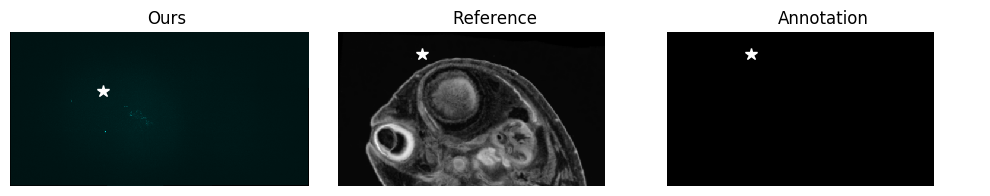

moving slice shape:  (260, 450) , pt:  [20, 100, 140] , is_raw?:  False
pt(z, y, x):  [20, 100, 140] , w(z, y, x):  [86, 42, 141] , label_no:  0


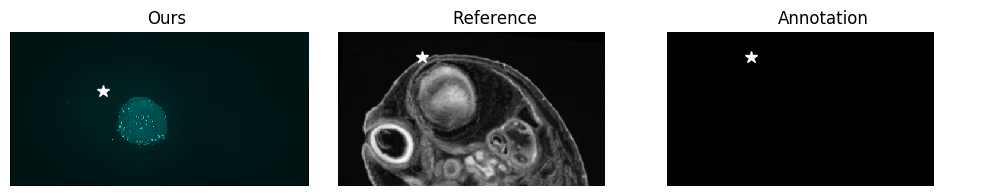

moving slice shape:  (260, 450) , pt:  [30, 100, 140] , is_raw?:  False
pt(z, y, x):  [30, 100, 140] , w(z, y, x):  [91, 49, 140] , label_no:  0


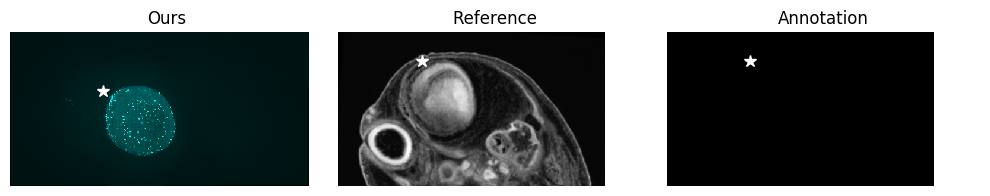

moving slice shape:  (260, 450) , pt:  [40, 100, 140] , is_raw?:  False
pt(z, y, x):  [40, 100, 140] , w(z, y, x):  [95, 56, 139] , label_no:  0


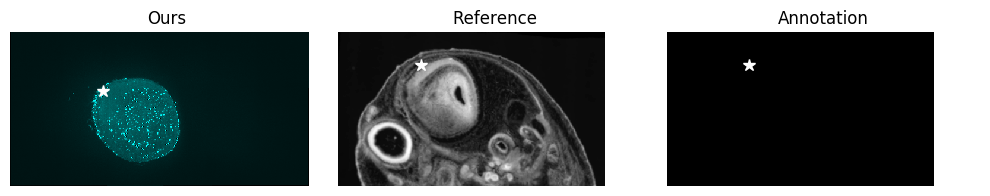

moving slice shape:  (260, 450) , pt:  [50, 100, 140] , is_raw?:  False
pt(z, y, x):  [50, 100, 140] , w(z, y, x):  [99, 64, 137] , label_no:  111220560


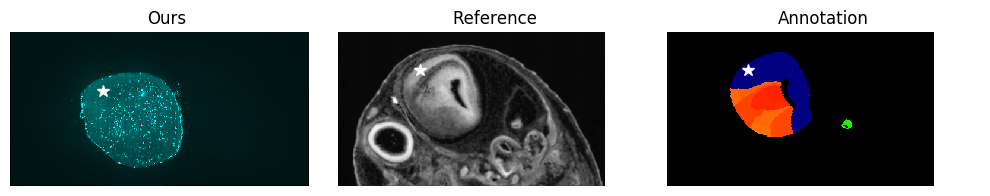

moving slice shape:  (260, 450) , pt:  [60, 100, 140] , is_raw?:  False
pt(z, y, x):  [60, 100, 140] , w(z, y, x):  [104, 72, 134] , label_no:  111220560


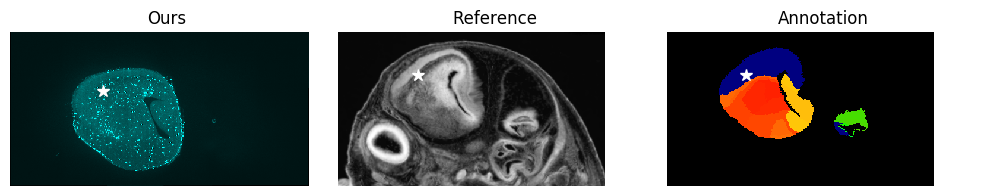

moving slice shape:  (260, 450) , pt:  [70, 100, 140] , is_raw?:  False
pt(z, y, x):  [70, 100, 140] , w(z, y, x):  [109, 77, 132] , label_no:  15983


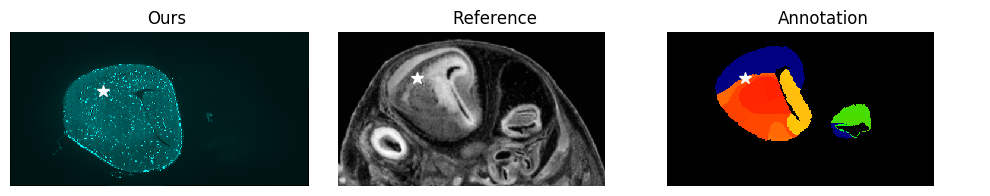

moving slice shape:  (260, 450) , pt:  [80, 100, 140] , is_raw?:  False
pt(z, y, x):  [80, 100, 140] , w(z, y, x):  [117, 79, 130] , label_no:  15932


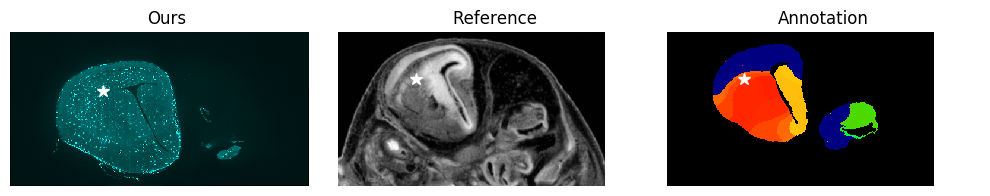

moving slice shape:  (260, 450) , pt:  [90, 100, 140] , is_raw?:  False
pt(z, y, x):  [90, 100, 140] , w(z, y, x):  [126, 78, 131] , label_no:  15932


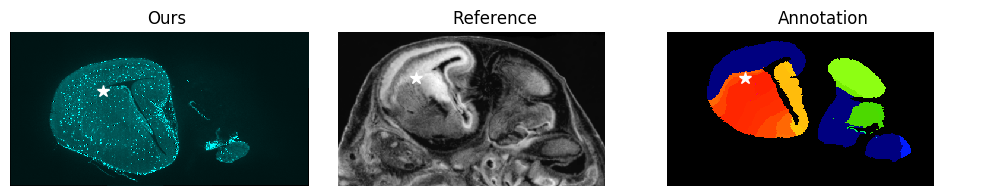

moving slice shape:  (260, 450) , pt:  [100, 100, 140] , is_raw?:  False
pt(z, y, x):  [100, 100, 140] , w(z, y, x):  [134, 76, 135] , label_no:  15854


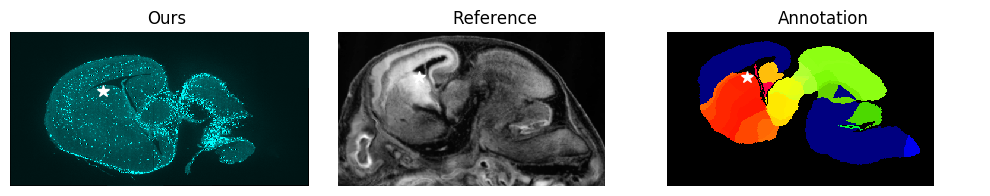

moving slice shape:  (260, 450) , pt:  [110, 100, 140] , is_raw?:  False
pt(z, y, x):  [110, 100, 140] , w(z, y, x):  [138, 76, 139] , label_no:  15854


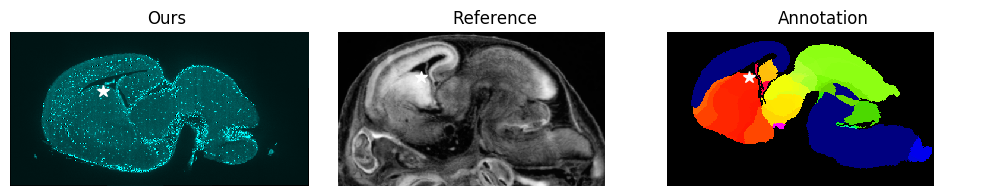

moving slice shape:  (260, 450) , pt:  [120, 100, 140] , is_raw?:  False
pt(z, y, x):  [120, 100, 140] , w(z, y, x):  [142, 78, 143] , label_no:  15854


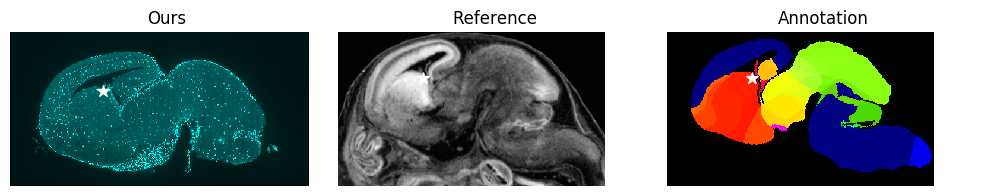

moving slice shape:  (260, 450) , pt:  [130, 100, 140] , is_raw?:  False
pt(z, y, x):  [130, 100, 140] , w(z, y, x):  [149, 82, 144] , label_no:  15852


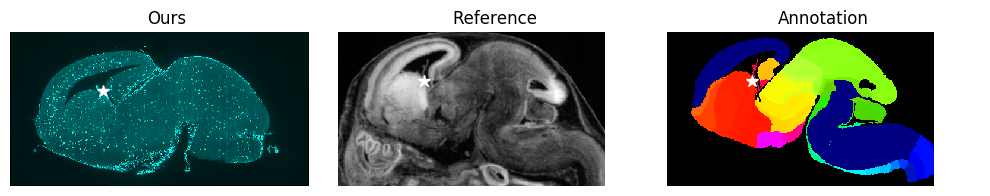

moving slice shape:  (260, 450) , pt:  [140, 100, 140] , is_raw?:  False
pt(z, y, x):  [140, 100, 140] , w(z, y, x):  [159, 88, 140] , label_no:  0


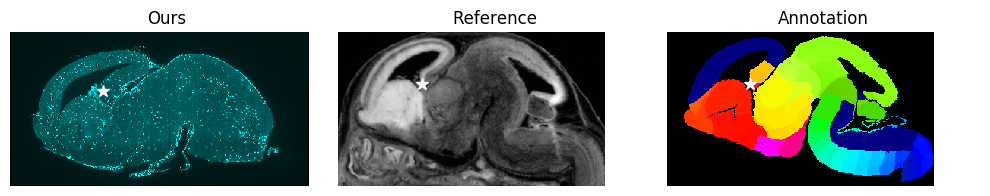

moving slice shape:  (260, 450) , pt:  [150, 100, 140] , is_raw?:  False
pt(z, y, x):  [150, 100, 140] , w(z, y, x):  [170, 99, 135] , label_no:  15750


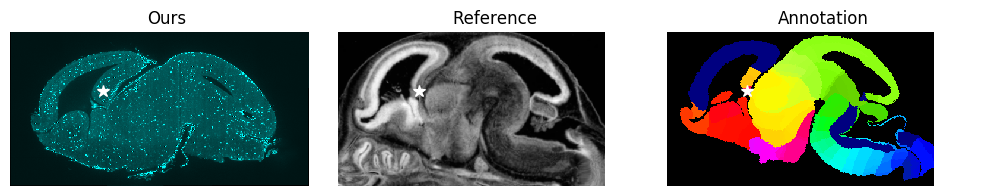

moving slice shape:  (260, 450) , pt:  [160, 100, 140] , is_raw?:  False
pt(z, y, x):  [160, 100, 140] , w(z, y, x):  [179, 110, 135] , label_no:  15740


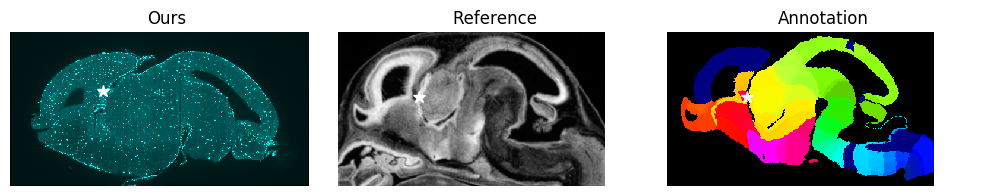

moving slice shape:  (260, 450) , pt:  [170, 100, 140] , is_raw?:  False
pt(z, y, x):  [170, 100, 140] , w(z, y, x):  [185, 121, 140] , label_no:  0


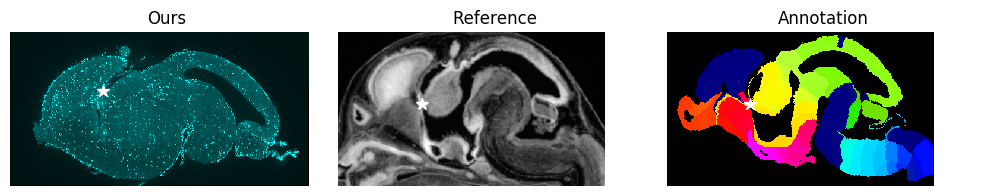

moving slice shape:  (260, 450) , pt:  [180, 100, 140] , is_raw?:  False
pt(z, y, x):  [180, 100, 140] , w(z, y, x):  [188, 127, 145] , label_no:  0


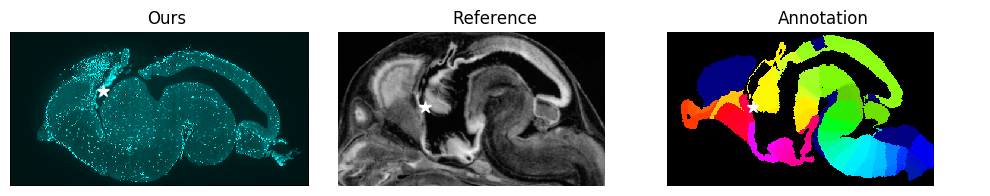

moving slice shape:  (260, 450) , pt:  [190, 100, 140] , is_raw?:  False
pt(z, y, x):  [190, 100, 140] , w(z, y, x):  [191, 130, 147] , label_no:  0


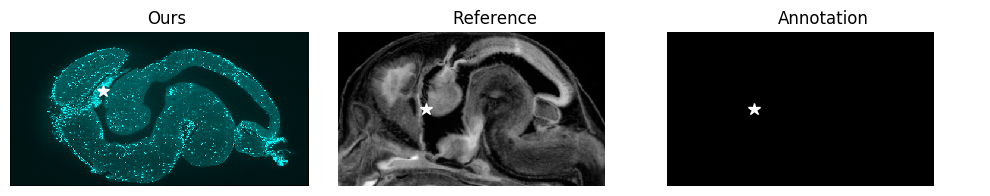

In [63]:
point = (roi_z, roi_y, roi_x) # (z, y, x)
point = [140, 100, 140]
figsize=(10, 5)
clim=[100, 4000]
ann_clim = [15000, 18000] # for E11.5, E13.5
for zz in range(10, 200, 10):
    point = [zz, 100, 140]
    zimg, afvol, animg, _, _, _ = align_point(ma, point, moving_tif, af_tif, params, figsize=figsize, map_slice=False, is_raw=False, clim=clim, ann_clim=ann_clim)

if False:
    fig.savefig("AlignmentPoint_Brain_%s_%s_zyx_%2d-130-210.png"%(params['name'], params['marker'], z))
    clim = params[params['marker']]['clim']
    zimg_raw, afvol_raw, animg_raw, _, fig, _ = align_point(ma_s, point, moving_tif, af_tif, raw_tiff_dir=raw_tiff_dir, raw_dim=params[params['marker']]['shape'],
                                                         ext=params['file_ext'], flip_x=align_info['flip_x'], flip_y=align_info['flip_y'], flip_z=align_info['flip_z'],
                                                         figsize=figsize, map_slice=False, is_raw=True,
                                                         clim=clim, ann_clim=ann_clim)

### Map a Slice

In [64]:
reference_image = tifffile.imread(af_tif)
moving_image = tifffile.imread(moving_tif) # downsampled TIF
moving_image.shape

(386, 260, 450)

#### Moving to Reference

In [65]:
aligned_image = align_image(ma.warper_r, moving_image, reference_image, ncpu=48)

Warping image: 100%|██████████████████████████████████████████████████████████████████████| 386/386 [01:37<00:00,  3.95it/s]


In [66]:
params['align_info']

{'aligned_on': 'AntiGFP',
 'alignment_json': '/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/AntiGFP_alignment.json',
 'ann_tif': '/media/share5/MYK/ATLAS/mouse/annotation_E15pt5_sagittal_brain.tif',
 'downsampled_tif': '/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/AntiGFP_downsampled_flipX_flipY.tif',
 'flip_x': True,
 'flip_y': True,
 'flip_z': False,
 'rescaled_alignment_json': '/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206/rescaled_AntiGFP_alignment.json',
 'xidx': 1,
 'yidx': 2,
 'zidx': 0}

zzz:  152


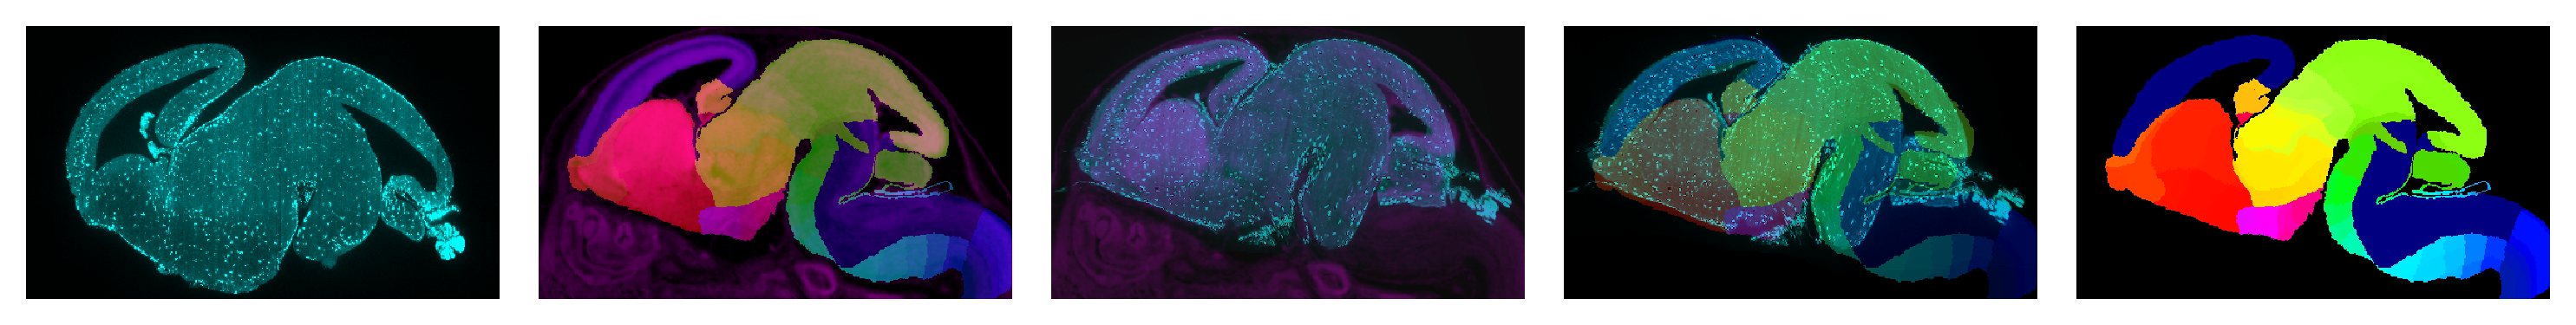

In [67]:
#m_z = roi_z
#m_z = point[0]
m_z = 225
if params['align_info']['xidx'] == 2:
    raw_h, raw_w = moving_zarr.shape[1:]
else:
    raw_w, raw_h = moving_zarr.shape[1:]
_, moving_h, moving_w = moving_image.shape
aspect_ratio = raw_w / raw_h
proper_w = int(aspect_ratio * moving_h)
try:
    mimg = cv2.resize(moving_image[m_z], dsize=(proper_w, moving_h))
    pad_w = (moving_w - proper_w) / 2.
    padded = np.pad(mimg,((0, 0), (int(pad_w), int(np.ceil(pad_w)))), mode='constant')
except:
    padded = moving_image[m_z]

if params['align_info']['flip_z']:
    zzz = m_z
else:
    zzz = moving_image.shape[0] - m_z

    
#zzz = 386-115
zzz = 152
print("zzz: ", zzz)
# DRAW
ann_img = ma.anns_mask[zzz]
#cmp = {'magenta': 'gist_earth', 'cyan': 'twilight_shifted_r'}
cmp = {'magenta': 'gist_earth', 'cyan': 'gist_ncar_r'}
#clim=[400, 700]
clim=[400, 3000]
fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=5, sharex=True, dpi=300)
ax[0].imshow(padded, cmap=cyan_r_cmp, clim=clim)
ax[1].imshow(reference_image[zzz], cmap=magenta_r_cmp, alpha=1.)
ax[1].imshow(ann_img, cmap=cmp['cyan'], clim=ann_clim, alpha=0.5)
ax[2].imshow(reference_image[zzz], cmap=magenta_r_cmp, alpha=0.9)
ax[2].imshow(aligned_image[zzz], cmap=cyan_r_cmp, clim=clim, alpha=0.6)
ax[3].imshow(aligned_image[zzz], clim=clim, cmap=cyan_r_cmp)
ax[3].imshow(ann_img, cmap=cmp['cyan'], clim=ann_clim, alpha=0.3)
ax[4].imshow(ann_img, cmap=cmp['cyan'], clim=ann_clim)
for aax in ax:
    aax.axis('off')
fig.tight_layout()
plt.show()
if True:
    fig.savefig("AlignmentMap_Brain_%s_%s_zyx_%2d.png"%(params['name'], params['marker'], zzz))

In [ ]:
figsize=(15,10)
ithr=300
zr = roi_z
damp = 4
nz = 1
slicemap = {}
savefig = False
#for z in tqdm(range(zr-damp, zr+damp)):
for z in [zr]:
    point = (z, roi_y, roi_x) # (z, y, x)
    zimg, afvol, animg, lblmap, w, ptx = align_point(ma, point, moving_tif, af_tif, params,
                                                  figsize=figsize, map_slice=True, is_raw=False, intensity_thr=ithr, ncpu=10, clim=clim, ann_clim=ann_clim)
    slicemap[z] = {}
    slicemap[z]['zimg'] = zimg
    slicemap[z]['afvol'] = afvol
    slicemap[z]['animg'] = animg
    slicemap[z]['lblmap'] = lblmap
    slicemap[z]['fig'] = fig
    slicemap[z]['pt'] = point
    slicemap[z]['warped_pt'] = w
    slicemap[z]['ptx'] = ptx
    

if savefig:
    fig.savefig("AlignmentMap_Brain_%s_%s_z%2d.png"%(params['name'], params['marker'], z))
    
if False:
    point=(roi_z, roi_y, roi_x)
    zimg_raw, afvol_raw, animg_raw, lblmap_raw, _ = align_point(ma_s, point, moving_tif, af_tif, params,
                                                                  raw_tiff_dir=raw_tiff_dir, raw_dim=params[params['marker']]['shape'],
                                                                  ext=params['file_ext'], flip_x=align_info['flip_x'], flip_y=align_info['flip_y'], flip_z=align_info['flip_z'],
                                                                  figsize=figsize, map_slice=True, is_raw=True, intensity_thr=ithr, ncpu=20, ann_clim=ann_clim)